In [57]:
import copy

class ChipPlacementOptimizer:
    def __init__(self, chips,connections ,GRID_WIDTH=10,GRID_HEIGHT=10):
        self.GRID_WIDTH = GRID_WIDTH
        self.GRID_HEIGHT = GRID_HEIGHT

        self.initial_chips = copy.deepcopy(chips)

        self.connections = connections

        self.chips = copy.deepcopy(self.initial_chips)
        self.iteration = 0
        self.best_score = float('inf')
        self.score_history = []

    def calculate_wiring_cost(self, chip1, chip2):
        x1, x2 = chip1['x'], chip2['x']
        w1, w2 = chip1['width'], chip2['width']
        y1, y2 = chip1['y'], chip2['y']

        horizontal_gap = max(0, x2 - (x1 + w1), x1 - (x2 + w2))
        vertical_gap = abs(y1 - y2)
        return horizontal_gap + vertical_gap

    def calculate_overlap_blocks(self, chip1, chip2):
        x1_start, x1_end = chip1['x'], chip1['x'] + chip1['width'] - 1
        y1_start, y1_end = chip1['y'], chip1['y'] + chip1['height'] - 1

        x2_start, x2_end = chip2['x'], chip2['x'] + chip2['width'] - 1
        y2_start, y2_end = chip2['y'], chip2['y'] + chip2['height'] - 1

        if (x1_end < x2_start or x2_end < x1_start or
            y1_end < y2_start or y2_end < y1_start):
            return 0

        overlap_x_start = max(x1_start, x2_start)
        overlap_x_end = min(x1_end, x2_end)
        overlap_y_start = max(y1_start, y2_start)
        overlap_y_end = min(y1_end, y2_end)

        overlap_width = overlap_x_end - overlap_x_start + 1
        overlap_height = overlap_y_end - overlap_y_start + 1

        return overlap_width * overlap_height

    def calculate_conflict_score(self):
        wiring_cost = 0
        overlap_cost = 0

        for i, j in self.connections:
            wiring_cost += self.calculate_wiring_cost(self.chips[i], self.chips[j])

        for i in range(len(self.chips)):
            for j in range(i + 1, len(self.chips)):
                overlap_cost += self.calculate_overlap_blocks(self.chips[i], self.chips[j])

        return {
            'total': wiring_cost + overlap_cost,
            'wiring': wiring_cost,
            'overlap': overlap_cost
        }

    def is_valid_position(self, chip, new_x):
        return (0 <= new_x <= self.GRID_WIDTH - chip['width'] and
                0 <= chip['y'] <= self.GRID_HEIGHT - chip['height'])

    def find_best_move(self):
        current_score = self.calculate_conflict_score()
        best_improvement = 0
        best_chip = -1
        best_direction = 0

        for chip_idx in range(len(self.chips)):
            chip = self.chips[chip_idx]
            original_x = chip['x']

            for direction in [-1, 1]:  # left & right
                new_x = original_x + direction
                if self.is_valid_position(chip, new_x):
                    chip['x'] = new_x
                    new_score = self.calculate_conflict_score()
                    improvement = current_score['total'] - new_score['total']

                    if improvement > best_improvement:
                        best_improvement = improvement
                        best_chip = chip_idx
                        best_direction = direction

                    chip['x'] = original_x  # restore

        return best_chip, best_direction, best_improvement

    def run_single_step(self):
        chip_idx, direction, improvement = self.find_best_move()
        if chip_idx >= 0 and improvement > 0:
            self.chips[chip_idx]['x'] += direction
            self.iteration += 1
            score = self.calculate_conflict_score()
            self.score_history.append(score['total'])
            self.best_score = min(self.best_score, score['total'])
            return True
        return False

    def run_optimization(self, max_iterations=1000, convergence_threshold=10):
        print("Starting chip placement optimization...")
        initial_score1=self.calculate_conflict_score()['total']
        print(f"Initial conflict score: {initial_score1}")
        self.score_history.append(initial_score1)

        no_improvement_count = 0

        while (self.iteration < max_iterations and
               no_improvement_count < convergence_threshold):

            if not self.run_single_step():
                no_improvement_count += 1
            else:
                no_improvement_count = 0
                if self.iteration % 10 == 0:
                    score = self.calculate_conflict_score()
                    print(f"Iteration {self.iteration}: Score = {score['total']} "
                          f"(Wiring: {score['wiring']}, Overlap: {score['overlap']})")

        print(f"\nOptimization stopped after {self.iteration} iterations")
        final_score = self.calculate_conflict_score()
        print(f"Final conflict score: {final_score['total']}")
        print(f"  Wiring cost: {final_score['wiring']}")
        print(f"  Overlap cost: {final_score['overlap']}")

    def print_final_results(self):
        print("\nFinal Chip Positions:")
        for chip in self.chips:
            print(f"Chip {chip['id']}: Position ({chip['x']}, {chip['y']}), "
                  f"Size {chip['width']}x{chip['height']}")
        print(f"Total iterations: {self.iteration}")

In [58]:
import matplotlib.pyplot as plt
import numpy as np

def plot_convergence(score_history):
    if not score_history:
        print("No optimization history to plot.")
        return

    plt.figure(figsize=(9, 5))
    iterations = np.arange(len(score_history))

    colors = plt.cm.viridis(np.linspace(0, 1, len(score_history)))

    for i in range(len(iterations) - 1):
        plt.plot(iterations[i:i+2], score_history[i:i+2], color=colors[i], linewidth=2.8)

    plt.scatter(iterations, score_history, c=colors, s=60, edgecolor='black', zorder=3)

    best_idx = np.argmin(score_history)
    plt.scatter(best_idx, score_history[best_idx],
                color='orange', s=160, edgecolor='black', linewidth=1.2,
                zorder=4, label=f'Best Score: {score_history[best_idx]} (iter {best_idx})')

    plt.title("Conflict Score Convergence", fontsize=16, weight='bold', color='darkblue')
    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Conflict Score", fontsize=14)

    plt.grid(alpha=0.25, linestyle='--')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12, loc="best", frameon=True, fancybox=True, shadow=True)
    plt.tight_layout()
    plt.savefig('convergence_plot.png', dpi=300)
    plt.show()


Starting chip placement optimization...
Initial conflict score: 40

Optimization stopped after 6 iterations
Final conflict score: 29
  Wiring cost: 20
  Overlap cost: 9

Final Chip Positions:
Chip 1: Position (1, 0), Size 2x4
Chip 2: Position (0, 1), Size 2x5
Chip 3: Position (3, 0), Size 1x3
Chip 4: Position (2, 4), Size 2x5
Chip 5: Position (4, 3), Size 2x4
Chip 6: Position (3, 2), Size 1x4
Chip 7: Position (0, 5), Size 2x5
Chip 8: Position (4, 6), Size 1x3
Total iterations: 6


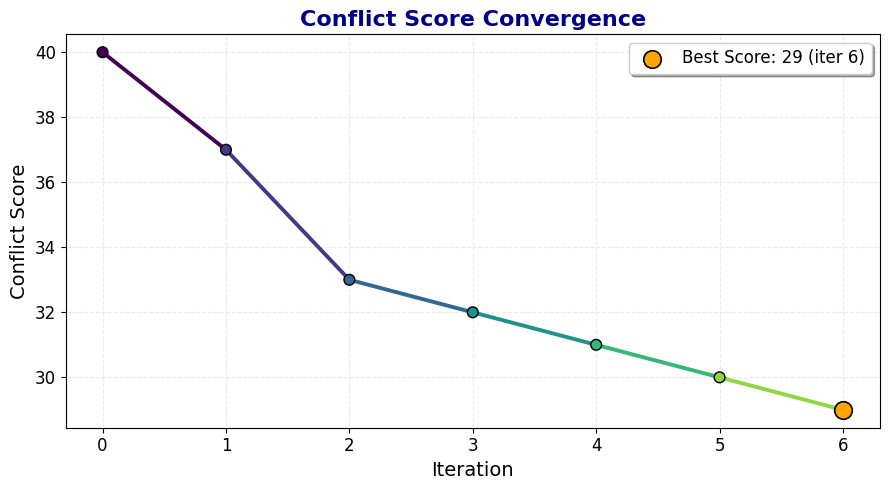

In [59]:
initial_chips = [
            {'id': 1, 'width': 2, 'height': 4, 'y': 0, 'x': 0},
            {'id': 2, 'width': 2, 'height': 5, 'y': 1, 'x': 1},
            {'id': 3, 'width': 1, 'height': 3, 'y': 0, 'x': 1},
            {'id': 4, 'width': 2, 'height': 5, 'y': 4, 'x': 2},
            {'id': 5, 'width': 2, 'height': 4, 'y': 3, 'x': 3},
            {'id': 6, 'width': 1, 'height': 4, 'y': 2, 'x': 2},
            {'id': 7, 'width': 2, 'height': 5, 'y': 5, 'x': 0},
            {'id': 8, 'width': 1, 'height': 3, 'y': 6, 'x': 4}
        ]
connections = [
            (0, 1), (1, 5), (1, 2), (2, 4), (3, 4),
            (4, 5), (0, 5), (6, 3), (6, 1), (7, 4)
        ]

optimizer = ChipPlacementOptimizer(chips=initial_chips,connections=connections)

optimizer.run_optimization()
optimizer.print_final_results()

plot_convergence(optimizer.score_history)